# Business Understanding

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. Ideally, we can find a comfortable place with an affordable price on Airbnb when traveling. In this project, we will use data provide by Kaggle to analyze how to make an informed decision when booking.

### Questions to answer from the data
1. What are the busiest times of the year to visit Seattle? Will prices fluctuate with visitor tendency?
2. What are the neighborhoods most requested by Airbnb customers?
3. What characteristics affects the price of a listing? 

In [1]:
#import required packages
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# Gather Data

- reviews: summary review data for the listing
- calendar: calendar data from the listing
- listing: summary information on listing in Seattle

In [2]:
reviews = pd.read_csv("/Users/ante/Desktop/DataScienstCourse/Project1/reviews.csv")
listing = pd.read_csv("/Users/ante/Desktop/DataScienstCourse/Project1/listings.csv")
calendar = pd.read_csv("/Users/ante/Desktop/DataScienstCourse/Project1/calendar.csv")

# Set option to show all columns while using head
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)

In [3]:
#reviews.head()
#listing.head()
#calendar

# Data Understanding

### First look at the data
1. What information we have
2. Which part in datasets lack information
3. genernal factor exists in all datasets

In [4]:
#shape of all dataframes
print ('reviews : ' + str(reviews.shape))
print('listing : ' + str(listing.shape))
print('calendar : ' + str(calendar.shape))

reviews : (84849, 6)
listing : (3818, 92)
calendar : (1393570, 4)


In [5]:
#check all dataframes columns type 
#listing.dtypes
#reviews.dtypes
#calendar.dtypes
print('reviews_date : ' + str(reviews.date.dtype))
print('calendar_price : ' + str(calendar.price.dtype))

reviews_date : object
calendar_price : object


In [6]:
#check summary statistic, like mean, median, percentile distribution
listing[['accommodates', 'bathrooms', 'bedrooms', 'guests_included',
       'number_of_reviews', 'review_scores_rating', 'review_scores_location', 'reviews_per_month']] .describe()

,accommodates,bathrooms,bedrooms,guests_included,number_of_reviews,review_scores_rating,review_scores_location,reviews_per_month
count,3818.000000,3802.000000,3812.000000,3818.000000,3818.000000,3171.000000,3163.000000,3191.000000
mean,3.349398,1.259469,1.307712,1.672603,22.223415,94.539262,9.608916,2.078919
std,1.977599,0.590369,0.883395,1.311040,37.730892,6.606083,0.629053,1.822348
min,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,4.000000,0.020000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,93.000000,9.000000,0.695000
50%,3.000000,1.000000,1.000000,1.000000,9.000000,96.000000,10.000000,1.540000
75%,4.000000,1.000000,2.000000,2.000000,26.000000,99.000000,10.000000,3.000000
max,16.000000,8.000000,7.000000,15.000000,474.000000,100.000000,10.000000,12.150000


In [7]:
#check missing value in all dataframes
#listing
colmissvalue = listing.columns[listing.isnull().mean() != 0]
listing_missingvalue = listing.loc[:, colmissvalue]
#reviews
reviewmissvalue = reviews.isnull().mean()
reviewmissvalue
#calendar
calendarmissvalue = calendar.isnull().mean()
calendarmissvalue

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


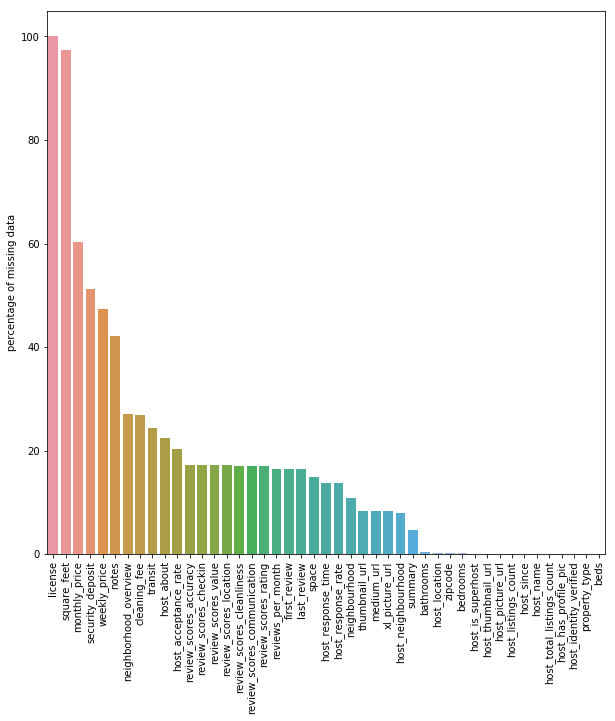

In [8]:
#plot the percentage of missing data for the columns in listing
missing_value = (listing_missingvalue.isnull().sum() * 100/listing_missingvalue.shape[0]).sort_values(ascending = False)
plt.figure(figsize = (10,10))
sns.barplot(missing_value.index, missing_value.values)
plt.xticks(rotation = 'vertical')
plt.ylabel('percentage of missing data')
# Save the PNG file on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/percentage of missing data in list.png')

plt.show()

In [9]:
#base on our observation, remove some columes which would not help us in analysis due to lack of information
listing = listing.drop(columns = ['license', 'square_feet'], axis=1, inplace=False)
#drop some of the columns which would helpless answer some of the listed questions above
listing = listing.drop(columns = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url',
                'host_url', 'availability_365'])

# Data Preparation

1. Format values to easier plot
2. Wrangling data : datasets should be merged into one using the listing identifier

In [10]:
def date_format(data, col):
    ''' convert object from str to date type
    
    inputs: data = pd.DataFrame
            col = list of columns
        
    outputs: pd.DataFrame     
    '''
    data[col] = pd.to_datetime(data[col])
    
    return data

def col_toboolean(data, col):
    ''' transform t/f to 1/0
    
    inputs: data = pd.DataFrame
            col = list of columns
        
    outputs: pd.DataFrame 
    '''
    data[col] = data[col].replace({'t':1, 'f':0}, inplace = True)
    #data[col] = data[col].astype('int')
    return data

def col_describedbool(data, col):
    ''' described then 1, else when no content then 0
    
    inputs:data = pd.DataFrame
           col = list of columns
        
    outputs: pd.DataFrame 
    '''
    data[col].where(data[col].isnull(), 1, inplace = True)
    data[col].mask(data[col].isnull(), 0, inplace = True)
    
    return data

def col_moneyformat(data, col):
    ''' transform money label to float
    
    inputs:data = pd.DataFrame
           col = list of columns
        
    outputs: pd.DataFrame 
    '''
    data[col] = data[col].str.replace('$', '').str.replace(',', '').astype('float')
    return data
def col_topercentage(data, col):
    ''' convert object from str to float
    
    inputs: data = pd.DataFrame
            col = list of columns
        
    outputs: pd.DataFrame     
    '''
    data[col] = data[col].str.replace('%', '').astype('float')
    return data

# Exploratory Analysis

Most of our questions are about price

## remove colomn will not be used in our questions related analysis

In [11]:
#all listing have same value
listing['scrape_id'].unique()
listing['experiences_offered'].unique()

array(['none'], dtype=object)

In [12]:
#columns 'host_listings_count' and 'host_total_listings_count' show the same information
listing['host_listings_count'].equals(listing['host_total_listings_count'])

True

### remove analysis

- remove those columns with more than half missing data, all have same value, or sames value columns group


- urls: web address cannot be used to do analysis


- location: such as city, state and country are irrelevant since we only analysis Seattle data. We will frop        lattitude and longitude since we will focus on neighbourhood_cleansed


- since 'cleaning_fee', 'extra_people' and 'security_deposit' fee are defined independent of the price by Airbnb, we are not going to use them in our analysis.


- more than one week availablity related variable will not take here since this analysis focus on short term traveling

In [13]:
drop_list = ['name',
             'monthly_price', 
             'weekly_price',       
             'notes',
             'scrape_id',
             'last_scraped',
             'host_name',
             'host_location',
             'host_thumbnail_url', 
             'host_picture_url',
             'street',
             'city', 
             'state',
             'zipcode',
             'country_code', 
             'country',
             'market',
             'smart_location',
             'neighbourhood',
             'latitude', 
             'longitude',
             'host_total_listings_count',
             'experiences_offered',
             'jurisdiction_names',
             'calendar_updated',
             'has_availability',
             'guests_included',
             'minimum_nights',
             'maximum_nights', 
             'availability_30', 
             'availability_60',
             'availability_90', 
             'calendar_last_scraped',
             'host_listings_count',
             'calculated_host_listings_count',
             'neighbourhood_cleansed',
             'first_review', 
             'last_review',
             'extra_people',
             'cleaning_fee',
             'security_deposit']
listing = listing.drop(columns = drop_list)

### data format

In [14]:
#format date
listing = date_format(listing, 'host_since')
calendar = date_format(calendar, 'date')
reviews = date_format(reviews, 'date')

In [15]:
#format boolean
bool_list = ['require_guest_phone_verification',
            'require_guest_profile_picture',
            'instant_bookable',
            'requires_license',
            'is_location_exact',
            'host_identity_verified',
            'host_has_profile_pic',
            'host_is_superhost']
for item in bool_list:
    listing = col_toboolean(listing, item)

In [16]:
#format description boolean
description_list = ['summary',
                       'space',
                       'description',
                       'neighborhood_overview',
                       'transit',
                       'xl_picture_url',
                       'host_about'
                      ]

for item in description_list:
    listing = col_describedbool(listing, item)

In [17]:
# Convert price from str to num
calendar = col_moneyformat(calendar, 'price')

In [18]:
# Format Percentage
percent_list = ['host_acceptance_rate', 
                'host_response_rate']
for item in percent_list:
    listing = col_topercentage(listing, item)

In [19]:
#dummy generate
dummy_list = ['bed_type',
              'cancellation_policy',
              'host_response_time',
              'property_type',
              'room_type']

# Generate dummie features
dummy_df = pd.get_dummies(listing[dummy_list])
#append to listing 
listing[list(dummy_df)] = dummy_df
listing = listing.drop(columns = dummy_list)

In [20]:
#amenities summary
amenities = listing['amenities'].str.replace('"', '').str.replace('{', '').str.replace('}', '').str.replace('-', '_')
amenities = amenities.str.replace("(", '').str.replace(")", '').str.replace(' / ', '_')
amenities = amenities.str.replace('/', '_').str.replace(' ', '_')
amenities_summary = []

for row in amenities:
    eachrow = row.split(',')
    for each in eachrow:
        if each not in amenities_summary:
            amenities_summary.append(each)
amenities_summary.remove('')

In [21]:
#dummy generate for amenities
amenities_dummy = pd.DataFrame(dtype='object')
    
for index_df,value in enumerate(listing['amenities']):
    row_dict = {}
    row_df = pd.DataFrame(dtype='object')
    
    amenities_row = value.replace('"', '').replace('{', '').replace('}', '').replace('-', '_')
    amenities_row = amenities_row.replace("(", '').replace(")", '').replace(' / ', '_')
    amenities_row = amenities_row.replace('/', '_').replace(' ', '_')
    
    for amenity in amenities_summary:
        if amenity in amenities_row:
            row_dict[amenity] = 1
        else:
            row_dict[amenity] = 0 
    
    row_df = pd.DataFrame(row_dict, index = [index_df])
    amenities_dummy = pd.concat([amenities_dummy, row_df])

In [22]:
amenities_dummy.columns = 'Amenities_' + amenities_dummy.columns
listing = pd.concat([listing, amenities_dummy], axis = 1)
listing.drop(columns = 'amenities', inplace = True)

# Merge Data

In [23]:
listing = listing.rename(columns = {'id' : 'listing_id'})
df_merge = pd.merge(listing, calendar, on = 'listing_id')

In [24]:
# end of cleaning: output listing
pd.DataFrame(df_merge.columns).to_csv('/Users/ante/Desktop/DataScienstCourse/dataoutput/columns.csv')

# Exploratory And Visualization

### What are the busiest times of the year to visit Seattle? Will prices fluctuate with visitor tendency?

When it comes to Seattle’s busiest travel season, many vistors plan ahead and try to stay ahead of their availability windows. Adverse, vacancies become more during not busy time, so availablity of hosting will be a good standard for us to observe busiest times of general Seattle Airbnb market. Otherwise, lower occupany rate might cause less provider, so availability rate can provide more accurate data than just availability.

In [27]:
# list available hosting in each month and relative rate
df_busy = df_merge.loc[df_merge['date'] <'2017-01-01']
df_busy['month'] = pd.DatetimeIndex(df_busy['date']).month
df_busy_available = df_busy.loc[df_busy['available'] == 't']

monthly_list = pd.DataFrame(dtype='object')
monthly_list_all = pd.DataFrame(dtype = 'object')
monthly_avail = df_busy_available.groupby(by = ['month'], as_index = True)['listing_id'].nunique()
monthly_all = df_busy.groupby(by = ['month'], as_index = True)['listing_id'].nunique()

monthly_list = pd.DataFrame(monthly_avail)
monthly_list_all = pd.DataFrame(monthly_all)

#remove index
monthly_list.reset_index(level=0, inplace=True)
monthly_list_all.reset_index(level=0, inplace=True)

monthly_avail_all = pd.merge(monthly_list, monthly_list_all, on = 'month')
monthly_avail_all.rename(columns = {'listing_id_x': 'available', 'listing_id_y': 'all'}, inplace = True)
monthly_avail_all['available_rate'] = monthly_avail_all['available']/monthly_avail_all['all']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
monthly_avail_all

,month,available,all,available_rate
0,1,2868,3818,0.751179
1,2,2895,3818,0.758250
2,3,2950,3818,0.772656
3,4,3002,3818,0.786276
4,5,2705,3818,0.708486
5,6,2720,3818,0.712415
6,7,2503,3818,0.655579
7,8,2561,3818,0.670770
8,9,2649,3818,0.693819
9,10,2694,3818,0.705605


since every month have same host size, the available rate will be in the exact same tendency as availability, so we will put them in the same plot

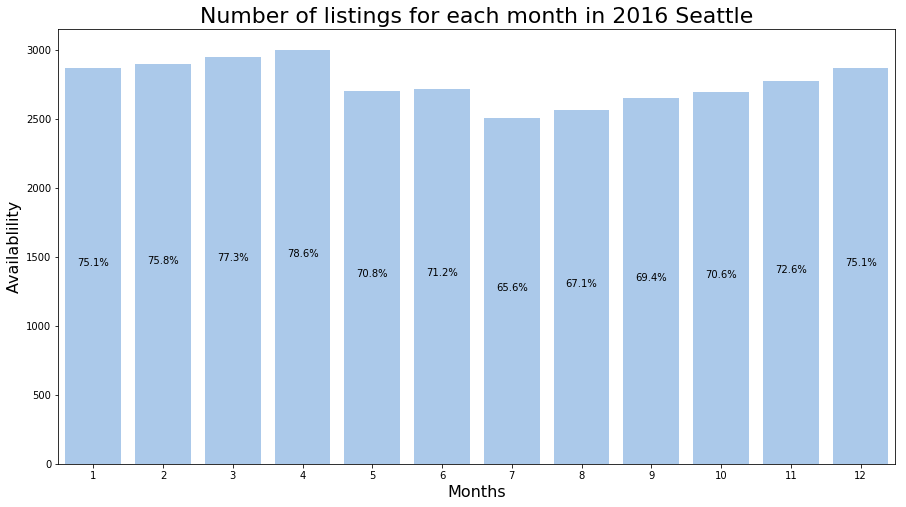

In [29]:
f, ax = plt.subplots(figsize = (15, 8))
base_color = sns.color_palette("pastel")[0]
avail_plot = sns.barplot(x= 'month', 
                         y= 'available',
                         data= monthly_avail_all,
                         color=base_color)

# Available rate of blue bar 
for index, row in monthly_avail_all.iterrows():
    avail_plot.text(row.name, row.available/2, f'{round((row.available_rate)*100,1)}%', color='black', ha="center")

# labels of the plot
avail_plot.axes.set_title("Number of listings for each month in 2016 Seattle", fontsize=22)
avail_plot.set_xlabel("Months", fontsize=16)
avail_plot.set_ylabel("Availablility", fontsize=16)

# Save the PNG file on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/number_of_listings_for_each_month_in_2016.png')

plt.show()
            

#### We are going to use the price from calendar, to evaluate how the time of the year affects the price, so we drop price in listing.

In [30]:
# Drop column 'price' from listing_df_cleansed
df_merge.drop(columns=['price_x'], inplace = True)
df_merge.rename(columns={'price_y':'price'}, inplace=True)

# Drop rows missing 'price' values
df_merge.dropna(subset=['price'], inplace = True)

The busiest time of the year to visit Seattle in 2016 will be the month with less available listings.
The period between July, August and September (Summertime) had the lowest vacancy percentages of 2016, so these 3 months would be the busiest time, do let's see will prices fluctuate with visitor tendency? If price peak happen in tJuly, August and September?

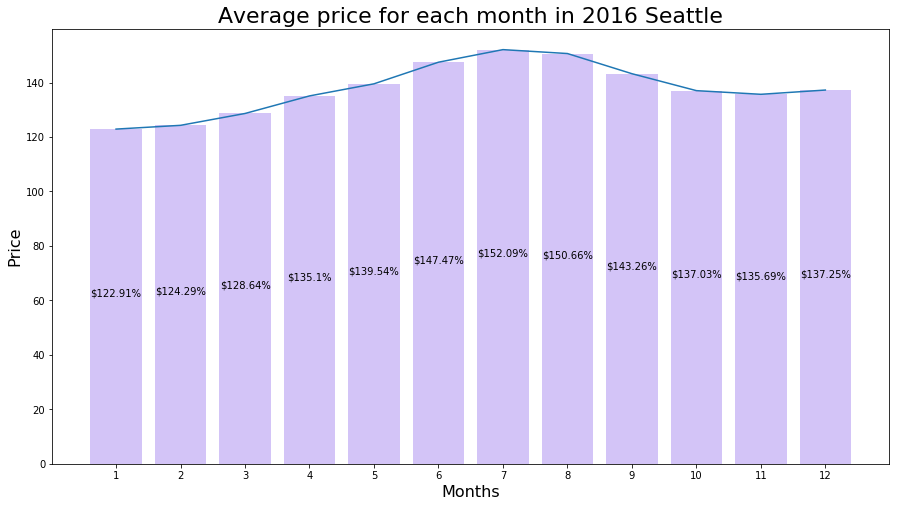

In [31]:
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
average_price_by_month = pd.DataFrame(data=calendar.groupby(['month'])['price'].mean(), index=range(1,13))
average_price_by_month.reset_index(level=0, inplace=True)
average_price_by_month.rename(columns = {'index':'month'}, inplace=True)

f, ax = plt.subplots(figsize = (15, 8))
base_color = sns.color_palette("pastel")[4]
price_plot = sns.barplot(x='month', 
                         y= 'price',
                         data= average_price_by_month,
                         color= base_color)


# Available rate of blue bar 
for index, row in average_price_by_month.iterrows():
    price_plot.text(row.name, row.price/2, f'${round(row.price,2)}%', color='black', ha="center")

# labels of the plot
price_plot.axes.set_title("Average price for each month in 2016 Seattle", fontsize=22)
price_plot.set_xlabel("Months", fontsize=16)
price_plot.set_ylabel("Price", fontsize=16)

price_lineplot = sns.lineplot(data = average_price_by_month['price'])

#Save the PNG file on folder 
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/Average_price_for_each_month_in_2016.png')

plt.show()

From above 2 plots, we can see the most busiest times in Seattle are between July and September, and the highest average price occurs between June and August, it almost overlap each other. So we can get conclusion that prices fluctuate with visitor tendency, but not in the exactly same trend. This might caused by visitor plan ahead before busier time and the web views and bookings might bias hoster and make them increase the price proritized.

### What are the neighborhoods most requested by Airbnb customers?

Location is an important factor for visitor to consider when they pick a place to stay for the vacation. Some neighborhoods are
more safe and more traffic convenient, which makes these neighborhoods are more attractive and more popular, that will affect 
the general price of those neighborhoods, so we can take price as reference when we analyze what are the neighborhoods most requested
by Airbnb customers


### price distribution

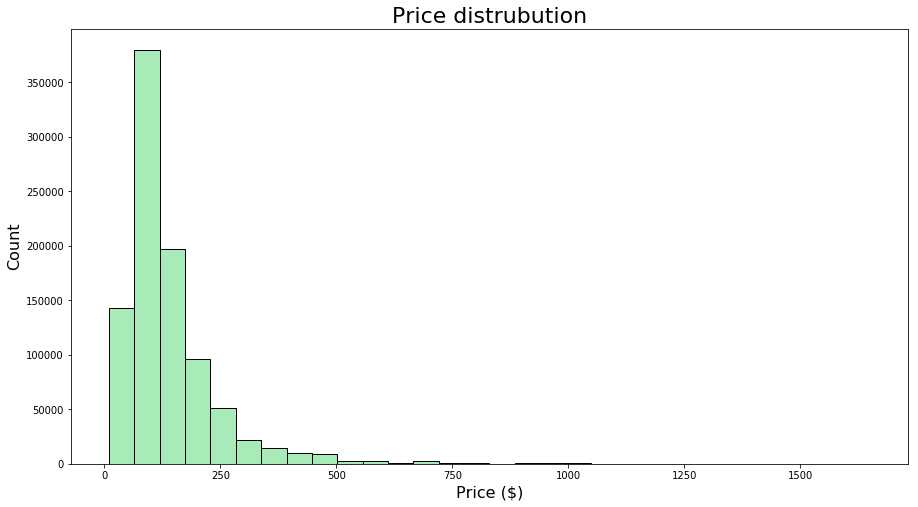

In [32]:
# Plot results
f, ax = plt.subplots(figsize = (15, 8))
base_color = sns.color_palette("pastel")[2]
price_plot = sns.histplot(x='price', 
                         data= df_merge,
                         color= base_color,
                         bins = 30)

#Lables and titles
price_plot.axes.set_title("Price distrubution", fontsize=22) 
price_plot.set_xlabel("Price ($)", fontsize=16)
price_plot.set_ylabel("Count", fontsize=16)

#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/Price_distribution.png')

plt.show()

we will drop outlier of price when do analysis of general relationship of neighborhood and price

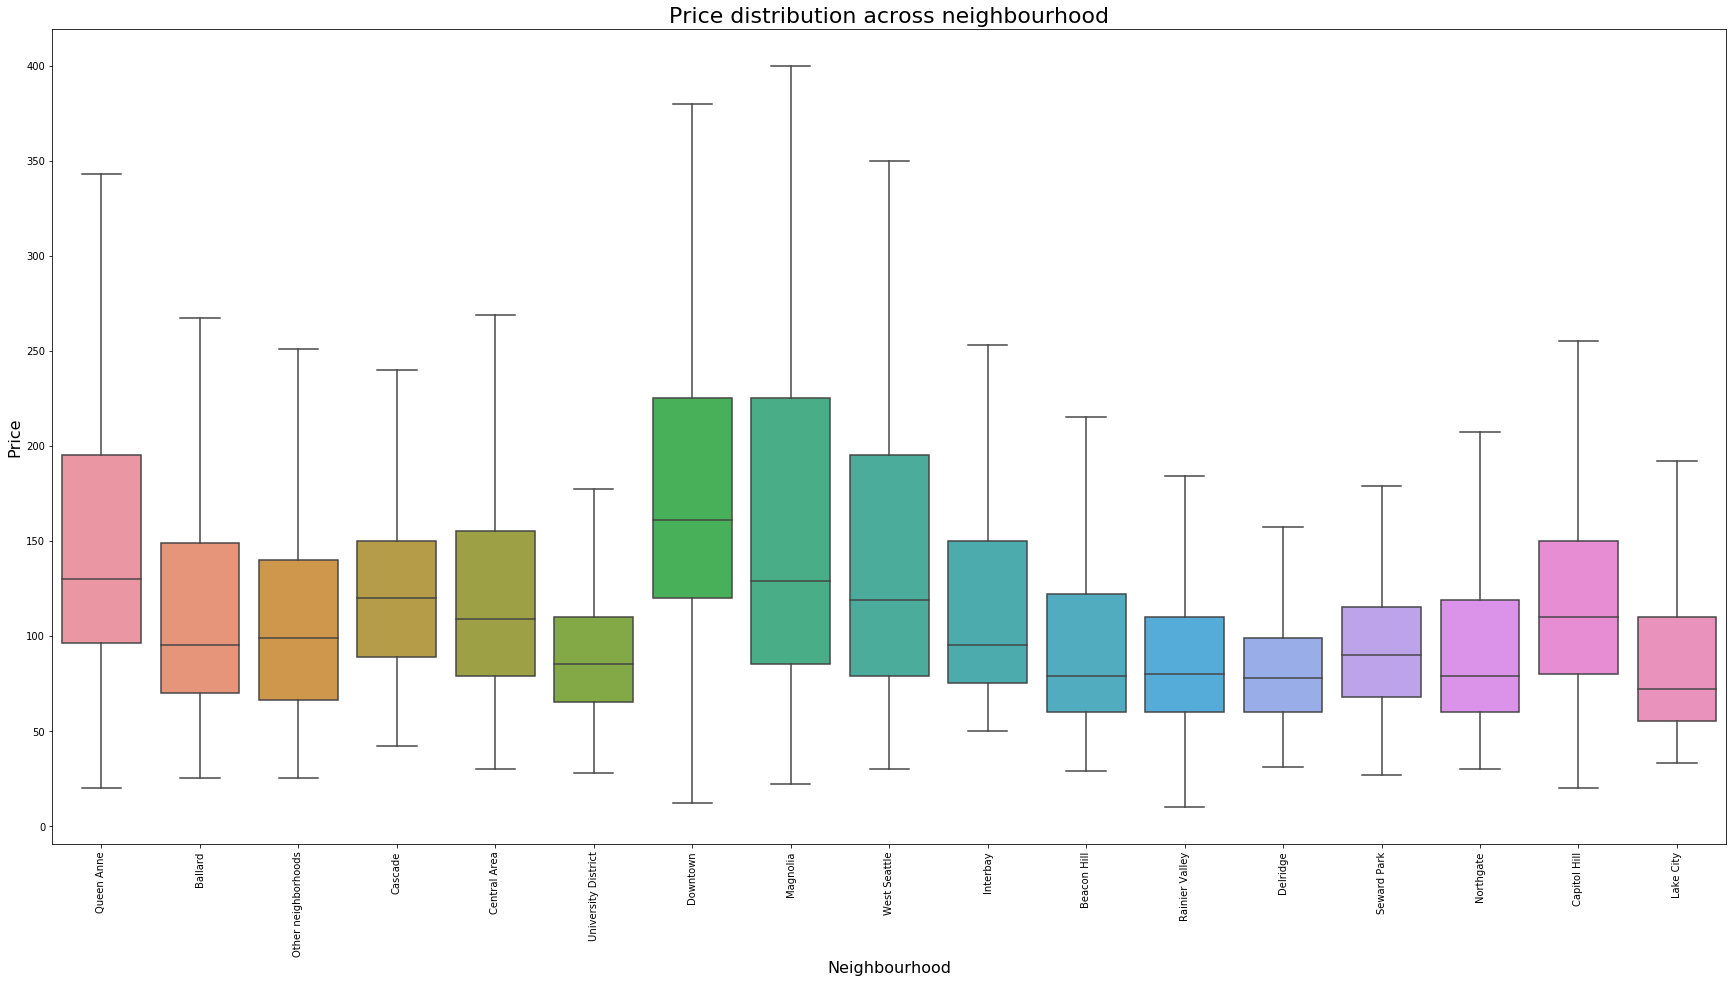

In [33]:
# Check the price variation across different neighbourhoods in Seattle to check the distribution of each

plt.figure(figsize = (30,15))
neighbourhood_plot = sns.boxplot(x='neighbourhood_group_cleansed', 
                                 y = 'price',
                                 data = df_merge.loc[df_merge['price'] <= 600],
                                 showfliers = False)

neighbourhood_plot.set_xticklabels(neighbourhood_plot.get_xticklabels(),rotation='vertical')

neighbourhood_plot.axes.set_title('Price distribution across neighbourhood', fontsize=22)
neighbourhood_plot.set_xlabel("Neighbourhood", fontsize=16)
neighbourhood_plot.set_ylabel("Price", fontsize=16)

#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/Price_distribution_across_neighbourhood.png')

plt.show()


In [34]:
#list average price for each neighbourhood in every month
df_merge_subset_avg = pd.DataFrame(dtype = 'object')
df_merge_subset = df_merge.loc[(df_merge['price'] <= 600)]
df_merge_subset['month'] = pd.DatetimeIndex(df_merge_subset['date']).month
df_merge_subset_avg = pd.DataFrame(df_merge_subset.groupby(['month','neighbourhood_group_cleansed'])['price'].mean())
df_merge_subset_avg.reset_index(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


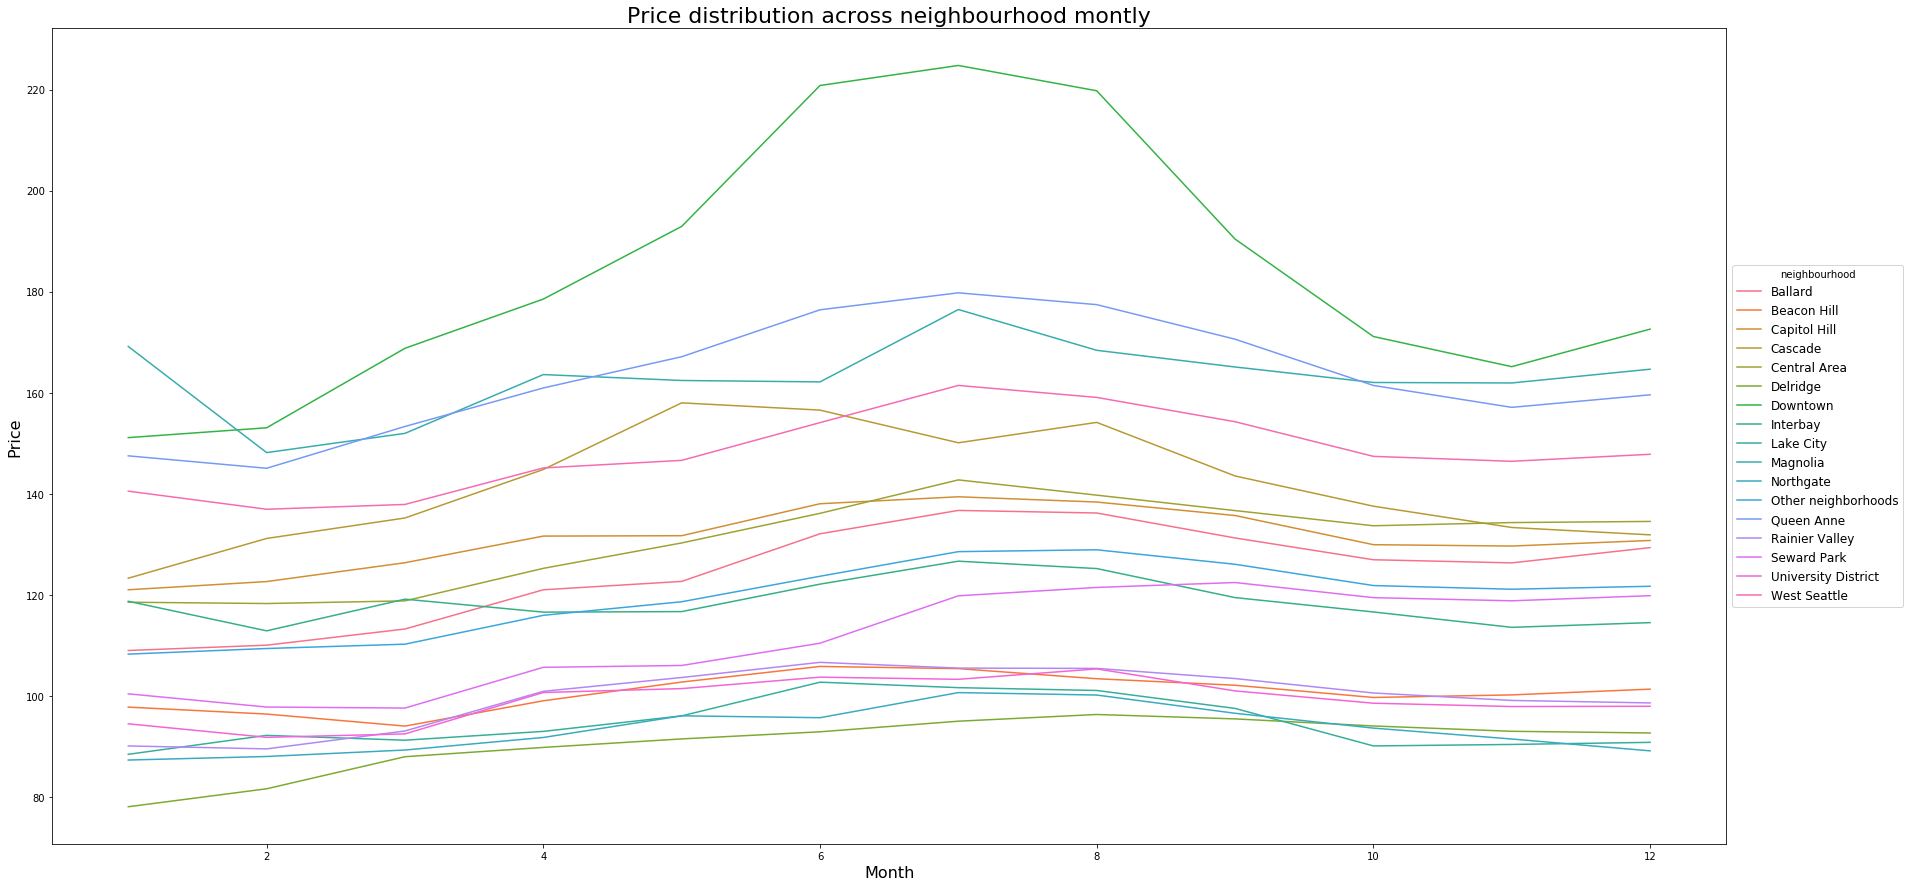

In [35]:
#Plot the price variation across different month in different neighbourhoods 

plt.figure(figsize = (30,15))
neighbourhood_monthly_plot = sns.lineplot(data=df_merge_subset_avg, 
                                          x="month", 
                                          y="price", 
                                          hue = 'neighbourhood_group_cleansed')

neighbourhood_monthly_plot.axes.set_title('Price distribution across neighbourhood montly', fontsize=22)
neighbourhood_monthly_plot.set_xlabel("Month", fontsize=16)
neighbourhood_monthly_plot.set_ylabel("Price", fontsize=16)
plt.legend(loc='center left', title='neighbourhood', bbox_to_anchor=(1, 0.5), fontsize=12)

#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/Price_distribution_across_neighbourhood_monthly.png')

plt.show()

From above 2 plots, we can see that Downtown, Magnolia, Queen Anne are the most expensive neighbourhoods in terms of Airbnb property listings, their prices change with time went on, but overall average above 150 dollars for a day each month, and more than 75 percent hoster charge more than 100 dollars for a night, compare to other neighborhoods cannot achieve this standard, so we conclude owntown, Magnolia, Queen Anne are the neighborhoods most requested by Airbnb customers.

### What characteristics affects the price of a listing? If general price increasing happened during the busiest time, what characteristics affected the price increasing?

Let's draw a Heatmap to see general correlation of numeric features first

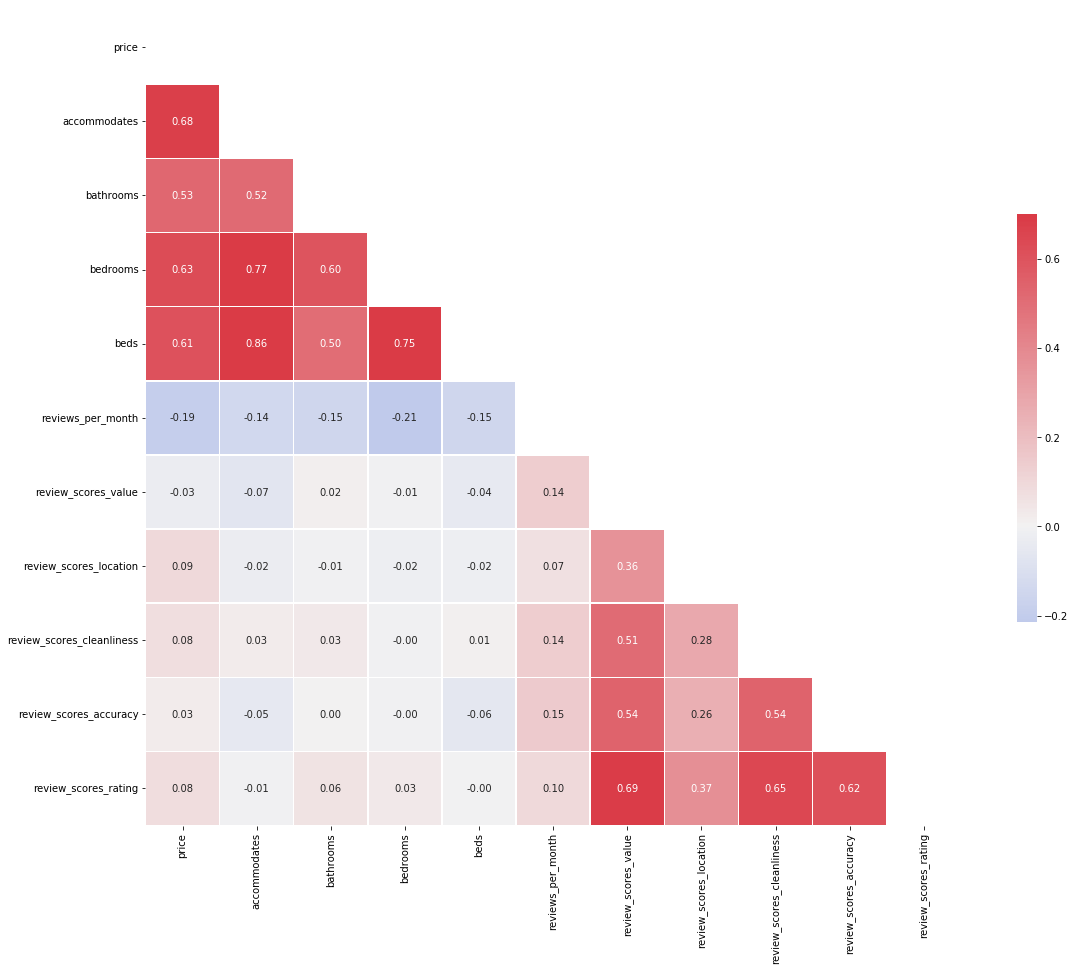

In [36]:
numerical_features = ['price',
           'accommodates',
           'bathrooms',
           'bedrooms',
           'beds',
          'reviews_per_month',
          'review_scores_value',
          'review_scores_location',
          'review_scores_cleanliness',
          'review_scores_accuracy',
          'review_scores_rating'
          ]
corr = df_merge[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
#sns.set(font_scale=1)
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.7, center=0,fmt = '.2f',
            square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = heatmap.get_figure()
fig.savefig('/Users/ante/Desktop/DataScienstCourse/Image/correlations.png')

from the heatmap, we can see that infrastructure have a huge impact on price

Let's analyze the price distribution for each dummy category

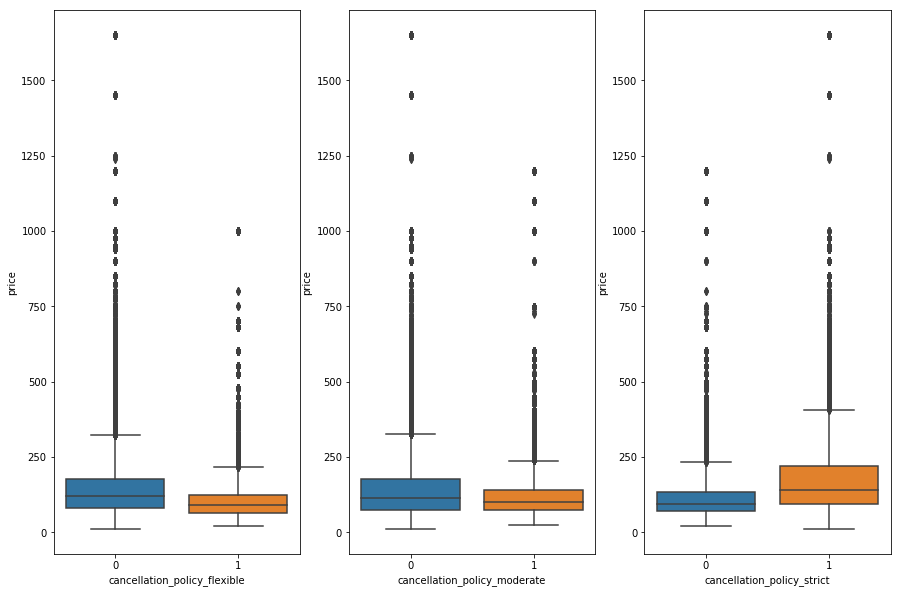

In [37]:
dummy_cancel_features = ['cancellation_policy_flexible',
 'cancellation_policy_moderate',
 'cancellation_policy_strict']

f, ax = plt.subplots(1, 3, figsize=(15,10))

for i, col  in enumerate(dummy_cancel_features):
    sns.boxplot( y='price', 
                 x= col, 
                 data=df_merge,  
                 orient='v', 
                 ax=ax[i])

#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/cancellation_dummy.png')  

base on above plots, it is obviously that cancellation policy more flexiable, the less price hoster charge

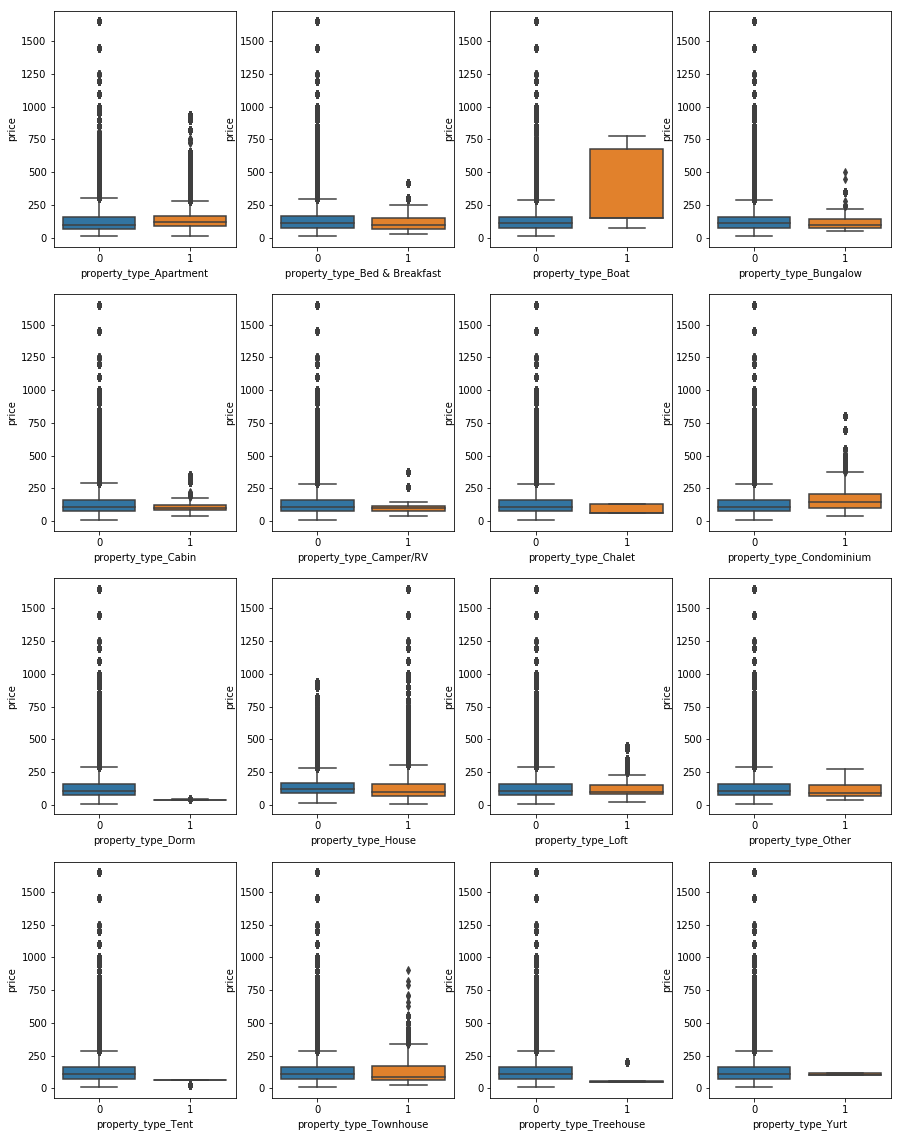

In [38]:
dummy_property_features = ['property_type_Apartment',
 'property_type_Bed & Breakfast',
 'property_type_Boat',
 'property_type_Bungalow',
 'property_type_Cabin',
 'property_type_Camper/RV',
 'property_type_Chalet',
 'property_type_Condominium',
 'property_type_Dorm',
 'property_type_House',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Tent',
 'property_type_Townhouse',
 'property_type_Treehouse',
 'property_type_Yurt']

plt.figure(figsize=(15,20))
for i, col in enumerate(dummy_property_features):
    plt.subplot(4,4,i+1)
    
    sns.boxplot( y='price', 
                 x= col, 
                 data=df_merge,  
                 orient='v')
    
#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/property_dummy.png') 

From above plots, we can see that people prefer to stay in house rather than other more causal living way, like cabin, tent andtreehouse...
Because the house, townhouse charge more prices averagely.

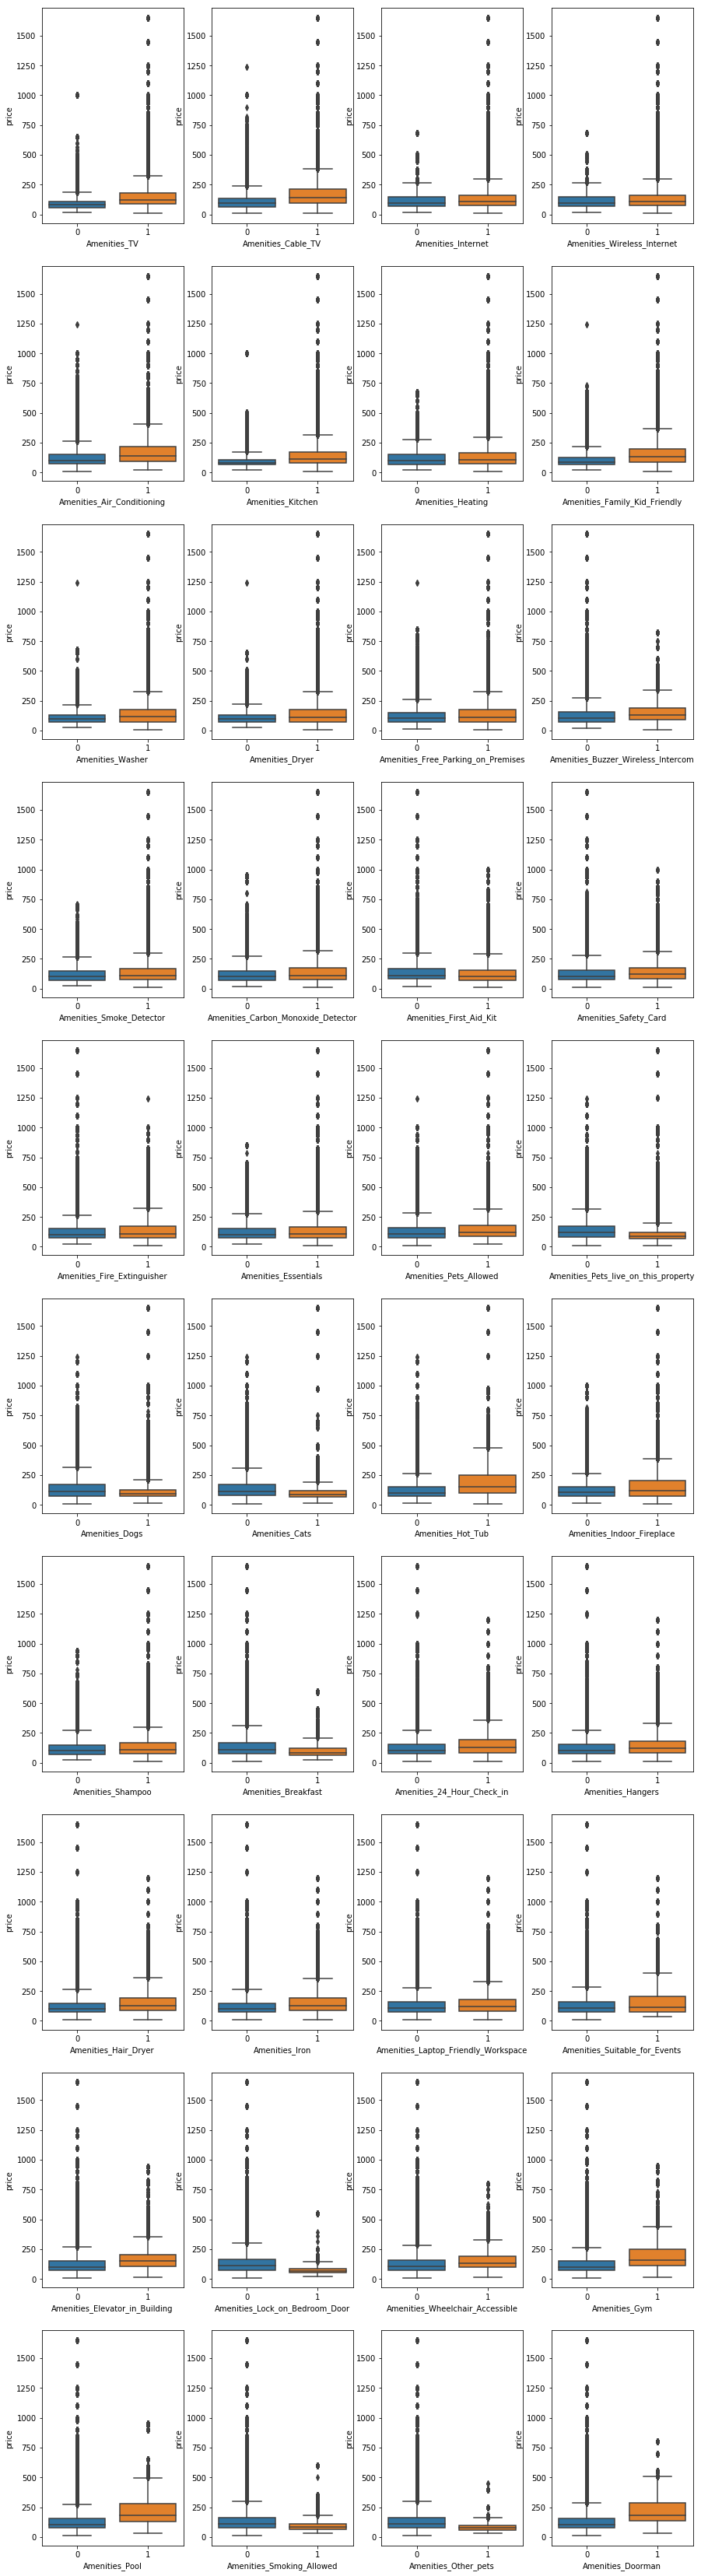

In [39]:
dummy_amenities_features = ['Amenities_TV',
 'Amenities_Cable_TV',
 'Amenities_Internet',
 'Amenities_Wireless_Internet',
 'Amenities_Air_Conditioning',
 'Amenities_Kitchen',
 'Amenities_Heating',
 'Amenities_Family_Kid_Friendly',
 'Amenities_Washer',
 'Amenities_Dryer',
 'Amenities_Free_Parking_on_Premises',
 'Amenities_Buzzer_Wireless_Intercom',
 'Amenities_Smoke_Detector',
 'Amenities_Carbon_Monoxide_Detector',
 'Amenities_First_Aid_Kit',
 'Amenities_Safety_Card',
 'Amenities_Fire_Extinguisher',
 'Amenities_Essentials',
 'Amenities_Pets_Allowed',
 'Amenities_Pets_live_on_this_property',
 'Amenities_Dogs',
 'Amenities_Cats',
 'Amenities_Hot_Tub',
 'Amenities_Indoor_Fireplace',
 'Amenities_Shampoo',
 'Amenities_Breakfast',
 'Amenities_24_Hour_Check_in',
 'Amenities_Hangers',
 'Amenities_Hair_Dryer',
 'Amenities_Iron',
 'Amenities_Laptop_Friendly_Workspace',
 'Amenities_Suitable_for_Events',
 'Amenities_Elevator_in_Building',
 'Amenities_Lock_on_Bedroom_Door',
 'Amenities_Wheelchair_Accessible',
 'Amenities_Gym',
 'Amenities_Pool',
 'Amenities_Smoking_Allowed',
 'Amenities_Other_pets',
 'Amenities_Doorman']

plt.figure(figsize=(15,60))
for i, col in enumerate(dummy_amenities_features):
    plt.subplot(10,4,i+1)
    
    sns.boxplot( y='price', 
                 x= col, 
                 data=df_merge,  
                 orient='v')
    
#Save the PNG image on folder
plt.savefig('/Users/ante/Desktop/DataScienstCourse/Image/Amenities_dummy.png') 

The more amenities, like pools, furnitures, the airbnb have, the more high prices. But pets and smoking allow, those thingd not everyone can accept, might lower the price of Airbnb.

# Predicting

To predict, we need to split our dataset into train and test, berfore that  we are going to fill the missing values.

In [40]:
df_missing = df_merge[df_merge.columns[df_merge.isnull().mean() != 0]]
df_missing.isnull().mean()

host_since                          0.000098
host_response_rate                  0.116115
host_acceptance_rate                0.182236
host_is_superhost                   1.000000
host_neighbourhood                  0.080454
host_has_profile_pic                1.000000
host_identity_verified              1.000000
is_location_exact                   1.000000
bathrooms                           0.005139
bedrooms                            0.002143
beds                                0.000391
review_scores_rating                0.154661
review_scores_accuracy              0.156806
review_scores_cleanliness           0.156150
review_scores_checkin               0.157102
review_scores_communication         0.155683
review_scores_location              0.156243
review_scores_value                 0.156348
requires_license                    1.000000
instant_bookable                    1.000000
require_guest_profile_picture       1.000000
require_guest_phone_verification    1.000000
reviews_pe

we will drop columns all with null values here, and in order to have enough rows to train our model and use some numerical variables, we are going to fill the missing values with the mean of the column. 
This dilutes the importance of this rows, beacuse we reduce its variabilty, but this allows ues to not remove too many rows and avoid model overfitting.

In [41]:
df_merge.drop(columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
                        'requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'],
              inplace = True)
df_fill_mean = ['review_scores_checkin', 
                'review_scores_accuracy',
                'review_scores_value',
                'review_scores_location',
                'review_scores_cleanliness',
                'review_scores_communication',
                'review_scores_rating',
                'reviews_per_month',
                'bathrooms', 
                'bedrooms', 
                'beds',
                'host_acceptance_rate', 
                'host_response_rate']

fillmissing = lambda col: col.fillna(col.mean())
df_merge[df_fill_mean] = df_merge[df_fill_mean].apply(fillmissing, axis = 0)


In [46]:
X = df_merge.drop(columns=['listing_id','price','date', 'host_since', 'host_id', 'available', 'host_neighbourhood', 'host_verifications', 'neighbourhood_group_cleansed'])
y = df_merge['price'].astype('float')

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)

#Score using your model
test_score = r2_score(y_test, y_test_preds)

test_score

-1.2358255717132298

The r-squared value of -1.24 is not pretty ideal to predict a price with accuracy, it might for the reason that too much feature here,
lead to the result that our model is suffering from Curse of dimensionality. Let's see what reduce the number of variables can give to us.


In [43]:
rf= RandomForestClassifier(n_estimators= 30)
rf.fit(X_train, y_train)
col_sorted_by_importance= rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})

feat_imp_top = feat_imp.nlargest(10, 'imps')

In [44]:
feat_imp_top

,cols,imps
93,reviews_per_month,0.060360
92,number_of_reviews,0.053575
91,review_scores_rating,0.043927
90,host_response_rate,0.032158
89,accommodates,0.030502
88,review_scores_location,0.021263
87,review_scores_value,0.021177
86,review_scores_cleanliness,0.020934
85,bathrooms,0.020469
84,review_scores_accuracy,0.019376


from above table, we can see that reviews are the most important features for visitor to define a hosting worth it's price or not,
then how well the infrastructure of aribnb also afftect visitor's judge a lot

In [45]:
feat_imp_top_col = ['reviews_per_month', 'number_of_reviews', 'review_scores_rating','accommodates', 'host_response_rate',
                   'review_scores_value', 'review_scores_location','review_scores_cleanliness', 'review_scores_accuracy', 'Amenities_First_Aid_Kit']
X = df_merge[feat_imp_top_col]
y = df_merge['price'].astype('float')

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)

#Score using your model
test_score = r2_score(y_test, y_test_preds)

test_score

0.4879446118310259

Using the linear regression model, the reduction of the number of variable outputs a worse model, with a lower R2 score than the previous linear model, even with most important feature.
In this case, the more features we have, the better predition we can get.
